In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import watermark
from collections import Counter
# visualization
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline
# get rid of warnings
import warnings
warnings.filterwarnings('ignore')

# Plot styling
sns.set(style='white', context='notebook', palette='deep')
plt.rcParams[ 'figure.figsize' ] = 9 , 5

# Using the Notebook:

1. To execute/run a cell, hold shift and click return
2. Feel free to change parameter values and key words if you want to search the dataset for specific companies

# Introduction

2020 was a year of extreme uncertainty. Throughout the year, VS's adopted new assumptions and predictions as the the pandemic shifted the cores of most industries. The primary role of any successful VC is to be able to forsee the evolution and potential of different industries.<br>
Given the worlds top 50 VC's early-stage investments throughout 2020, this analysis aims to identify key trends directions different industries are moving in. This analysis pulls data from over 250 early stage investments made in 2020 from 50 top-tier early-stage VCs (both international and local ones). <br> You can find a list of VCs covered at the end of this notebook. On top of the analysis, the database of companies pulled represent great potential investment opportunities (Founder emails are added)

### Import and Restructure Data

In [2]:
data = pd.read_excel('Investments2020_.xlsx')
data.rename(columns={'Last Financing Deal Type': 'Funding Type'}, inplace=True)
data.rename(columns={'Last Financing Deal Type 2': 'Funding Series'}, inplace=True)
#copy data set
data_na = data.copy()
data_na.dropna(inplace=True)
pd.set_option("max_colwidth", 50)  #This value controls how much you can read

In [3]:
data.head()

,Company Name,Funding Type,Funding Series,Last Financing Size,Last Financing Valuation,Total Raised,Last Financing Date,Primary Industry Group,Primary Industry Sector,All Industries,Verticals,HQ Location,Year Founded,Active Investors,Keywords,Website,Description,Primary Contact,Primary Contact Email
0,100Plus,Seed Round,Seed Round,15.0,NaN,15.00,2020-04-24,Healthcare Devices and Supplies,Healthcare,"Diagnostic Equipment*, Electronics (B2C), Medi...","Digital Health, TMT, Wearables & Quantified Self","San Francisco, CA",2016.0,"8VC, Ali Partovi, Ammunition Design Group, Ban...","heart monitor, heart monitoring device, remote...",www.100plus.com,Developer of remote patient monitoring platfor...,Ryan Howard,ryan@100plus.com
1,1upHealth,Early Stage VC,Series A,8.0,30.0,10.35,2020-02-05,Healthcare Technology Systems,Healthcare,"Medical Records Systems*, Other Healthcare Ser...","Digital Health, HealthTech, TMT","Boston, MA",2017.0,"Advisors.Fund, Boston Children's Hospital, Eni...","clinical hospital data, fhir api platform, hea...",www.1up.health,Developer of a healthcare data platform design...,Ritwik Sahu,rsahu@1up.health
2,Abacus.AI,Early Stage VC,Series B,22.0,102.0,40.25,2020-10-23,Commercial Services,Business Products and Services (B2B),"Business/Productivity Software, IT Consulting ...","Artificial Intelligence & Machine Learning, Bi...","San Francisco, CA",2019.0,"Avichal Garg, Coatue Management, Decibel Partn...","artificial intelligence platform, artificial i...",www.abacus.ai,Provider of an artificial intelligence platfor...,Bindu Reddy,bindu@abacus.ai
3,Able.,Later Stage VC,Series B,7.0,20.0,11.50,2020-02-10,Software,Information Technology,"Business/Productivity Software*, Human Capital...","HR Tech, Mobile, SaaS","Cleveland, OH",2014.0,"JumpStart, M25, North Coast Ventures, Ohio Inn...","hiring platform, interview screening, online h...",www.ableteams.com,Developer of a cloud-based onboarding and cand...,Gerald Hetrick,gerald@employstream.com
4,Abnormal Security,Early Stage VC,Series B,50.0,600.0,74.00,2020-11-18,Software,Information Technology,Network Management Software*,"Artificial Intelligence & Machine Learning, Cy...","San Francisco, CA",2018.0,"Greylock Partners, Menlo Ventures","business email security, email fraud security,...",www.abnormalsecurity.com,Developer of a cloud email security platform d...,Evan Reiser,evan@abnormalsecurity.com


# Auxiliary Functions

In [4]:
#clean data

#Aux Functions
#break down each column by row types which are a string into a list and concat them Ex: "AI, FinTech, Life Sciences" -->> ["AI, FinTech, Life Sciences"]
def count_verticals(data, col_name):    

    verticals_list = []
    #iterate over the entire "verticals" column
    for index, row in data.iterrows():
        #accevalue_countstical value

        verticals_list = verticals_list + (row[col_name].replace(", ", ",").replace("*", "").split(","))

    return Counter(verticals_list)  

words_to_del_list = [' TMT', 'TMT', ' SaaS', 'SaaS', 'Artificial Intelligence & Machine Learning', '', ' Mobile', 'Mobile', ' Artificial Intelligence & Machine Learning', ' Mobile Commerce']

def delete_non_rel_vert(counts, list_=words_to_del_list):
    for word in list_:
        del counts[word]
    return counts
    

#plotting functions
def bar_plot(data, col_name):

    plt.figure(figsize = (15, 10))

    col_data = data[col_name].value_counts()
    x = list(col_data.index)
    y = list(col_data.values)

    plt.xlabel(col_name)
    plt.ylabel("Frequency")
    plt.title(col_name + "Bar Plot")
    plt.bar(x=x, height=y, width=0.9, color='#86bf91')

    col_data_percent = (col_data)/(col_data.sum())*100
    df = pd.DataFrame([col_data, col_data_percent])
    df.index = [col_name, "% of Total"]
    plt.xticks(rotation=90);
    
    return df


def hist_plot(title, col, col_name, bins):
    ax = col.hist(bins=bins, grid=False, figsize=(8,6), color='#86bf91', zorder=2, rwidth=0.9)
    
    # Despine
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.figure(figsize = (15, 10))
    # Draw horizontal axis lines
    vals = ax.get_yticks()
    for tick in vals:
        ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    ax.set_title(title, weight='bold', size=16)

    # Set x-axis label
    ax.set_xlabel(col_name, labelpad=20, weight='bold', size=12)

    # Set y-axis label
    ax.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)
    
    series = col.value_counts()
    series_percent = (series)/(series.sum())*100
    exit_df = pd.DataFrame([series, series_percent])
    exit_df.index = [col_name, "% of Total"]
    plt.xticks(rotation=90);
    
    return exit_df

def plot_stacked(data, seed, early, later, col_name, counts):    
    HQ_10_df = data[col_name].value_counts().index[:counts]
    HQ_10_seed = data_seed.loc[data_seed[col_name].isin(HQ_10_df)]
    HQ_10_early = data_early.loc[data_early[col_name].isin(HQ_10_df)]
    HQ_10_later = data_later.loc[data_later[col_name].isin(HQ_10_df)]
    plt.figure(figsize = (15, 10))
    #edit seed HQ so shapes are all equal
    HQ_10_seed = HQ_10_seed[col_name].value_counts().sort_index()
    if col_name == 'HQ Location':
        MV = pd.Series([0], index=["Mountain View, CA"])
        HQ_10_seed = HQ_10_seed.append(MV).sort_index()
    
    HQ_10_early = HQ_10_early[col_name].value_counts().sort_index()
    HQ_10_later = HQ_10_later[col_name].value_counts().sort_index()

    d = {'Seed' : HQ_10_seed, 
          'Early' : HQ_10_early,
        'Later' : HQ_10_later} 
    
    df_grouped = pd.DataFrame(d)
    if col_name == 'Year Founded':
        df_grouped.index = df_grouped.index.map(str)

    fields = ['Seed','Early','Later']
    colors = ['#1D2F6F', '#8390FA', '#86bf91']
    labels = ['Seed','Early','Later']
    # figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 10))
    # plot bars
    left = len(df_grouped) * [0]
    for idx, name in enumerate(fields):
        plt.barh(df_grouped.index, df_grouped[name], left = left, color=colors[idx])
        left = left + df_grouped[name]
    # title, legend, labels
    plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
    plt.xlabel('Frequency')
    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # adjust limits and draw grid lines
    plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
    ax.set_axisbelow(True)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    plt.show()
    
    
def plot_stacked_vert(data_seed, data_early, data_later, col_name):   
    data_seed.fillna("", inplace=True)
    data_early.fillna("", inplace=True)
    data_later.fillna("", inplace=True)
    counts_seed = count_verticals(data_seed, col_name)
    counts_seed = delete_non_rel_vert(counts_seed)
    #order data by most common verticals
    verticals_seed = counts_seed.most_common(20)
    verticals_seed

    counts_early = count_verticals(data_early, col_name)
    counts_early = delete_non_rel_vert(counts_early)
    #order data by most common verticals
    verticals_early = counts_early.most_common(20)
    verticals_early


    counts_later = count_verticals(data_later, col_name)
    counts_later = delete_non_rel_vert(counts_later)
    #order data by most common verticals
    verticals_later = counts_later.most_common(20)

    df_seed = pd.DataFrame(verticals_seed, columns=[col_name, "Seed"])
    df_early = pd.DataFrame(verticals_early, columns=[col_name, "Early"])
    df_later = pd.DataFrame(verticals_later, columns=[col_name, "Later"])

    # df_seed
    df_all = pd.merge(df_seed, df_early,on=[col_name])
    df_all = pd.merge(df_all, df_later,on=[col_name])
    df_all.set_index(col_name, inplace=True)
    df_all

    df_grouped = df_all.copy()
    fields = ['Seed','Early','Later']
    colors = ['#1D2F6F', '#8390FA', '#86bf91']
    labels = ['Seed','Early','Later']
    # figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 10))
    # plot bars
    left = len(df_grouped) * [0]
    for idx, name in enumerate(fields):
        plt.barh(df_grouped.index, df_grouped[name], left = left, color=colors[idx])
        left = left + df_grouped[name]
    # title, legend, labels
    plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
    plt.xlabel('Frequency')
    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # adjust limits and draw grid lines
    plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
    ax.set_axisbelow(True)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    plt.show()
    
    
def hist_distribution(data_seed, data_early, data_later, col_name):
    seed = data_seed[col_name]
    early = data_early[col_name]
    later = data_later[col_name]
    print("Seed Average {} and Median are: {} and {}".format(col_name, seed.sum()/len(seed), seed.median()))
    print("Early (A/B) Average {} and Median are: {} and {}".format(col_name , early.sum()/len(early), early.median()))
    print("Later (C+) Average {} and Median are: {} and {}".format(col_name, later.sum()/len(later), later.median()))
    bins = np.linspace(0, 100, 20)
    plt.figure(figsize = (15, 10))
    plt.hist(seed, bins, alpha=0.8, label='Seed stage')
    plt.hist(early, bins, alpha=0.6, label='Early Stage (A/B)')
    plt.hist(later, bins, alpha=0.4, label='Later Stage (C+)')
    plt.legend(loc='upper right')
    plt.xlabel(col_name+" $ (M)")
    plt.ylabel("Frequency")
    plt.title("{} Distributions for Different Stages".format(col_name));




,Later Stage VC,Early Stage VC,Seed Round,Corporate
Funding Type,347.000000,320.000000,228.000000,4.000000
% of Total,38.598443,35.595106,25.361513,0.444939


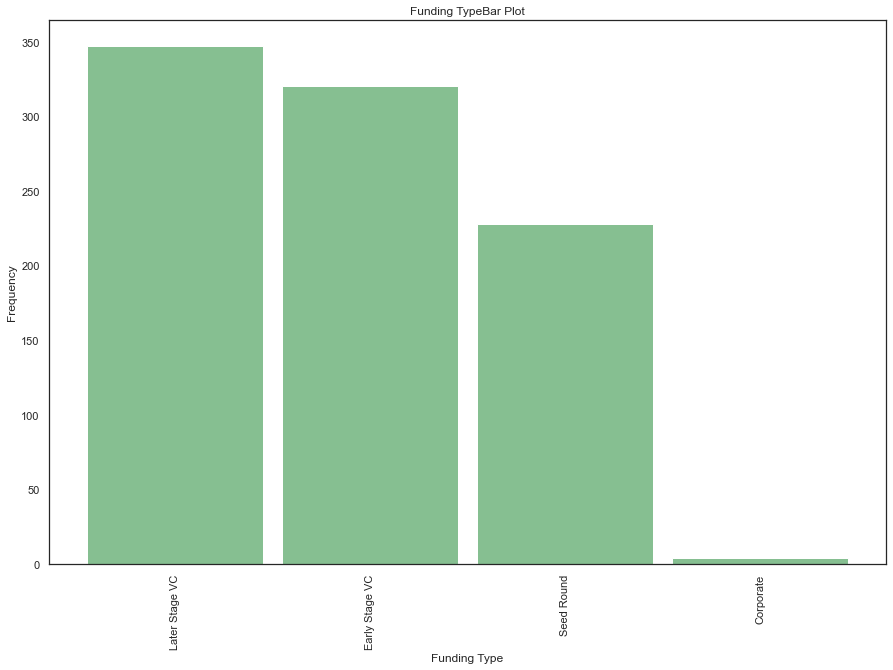

In [5]:
bar_plot(data, "Funding Type")

### Financing Round Size Distribution Per Investment Stage

In [6]:
#seperate data by Stage
data_seed = data[data['Funding Type'] == "Seed Round"]
data_early = data[data['Funding Type'] == "Early Stage VC"]
data_later = data[data['Funding Type'] == "Later Stage VC"]

Seed Average Last Financing Size and Median are: 4.724956140350877 and 3.725
Early (A/B) Average Last Financing Size and Median are: 27.1169375 and 17.0
Later (C+) Average Last Financing Size and Median are: 78.22610951008646 and 45.0


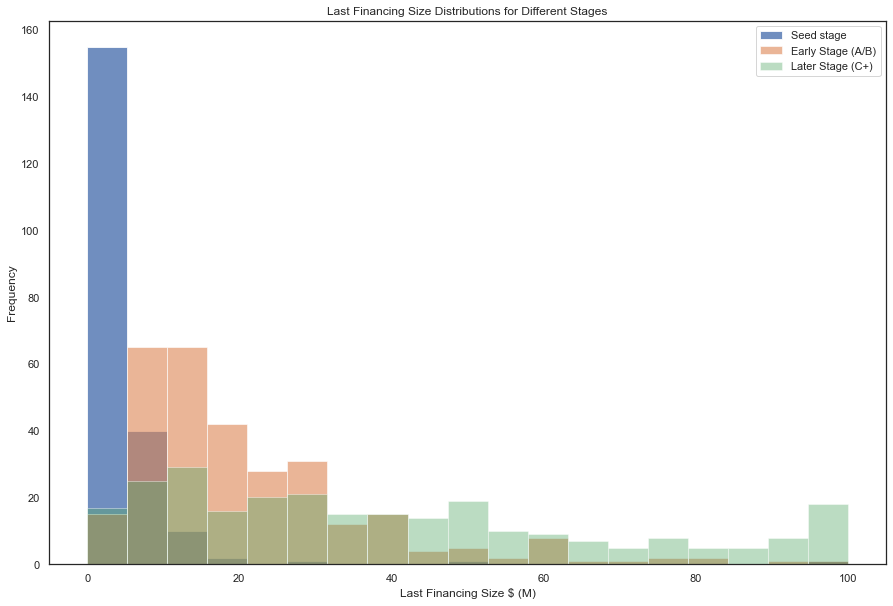

In [7]:
hist_distribution(data_seed, data_early, data_later, "Last Financing Size")

### Valuation Amound Distribution per Stage 

Seed Average Last Financing Valuation and Median are: 11.433026315789474 and 13.75
Early (A/B) Average Last Financing Valuation and Median are: 63.80340625 and 65.76
Later (C+) Average Last Financing Valuation and Median are: 575.9915850144092 and 365.0


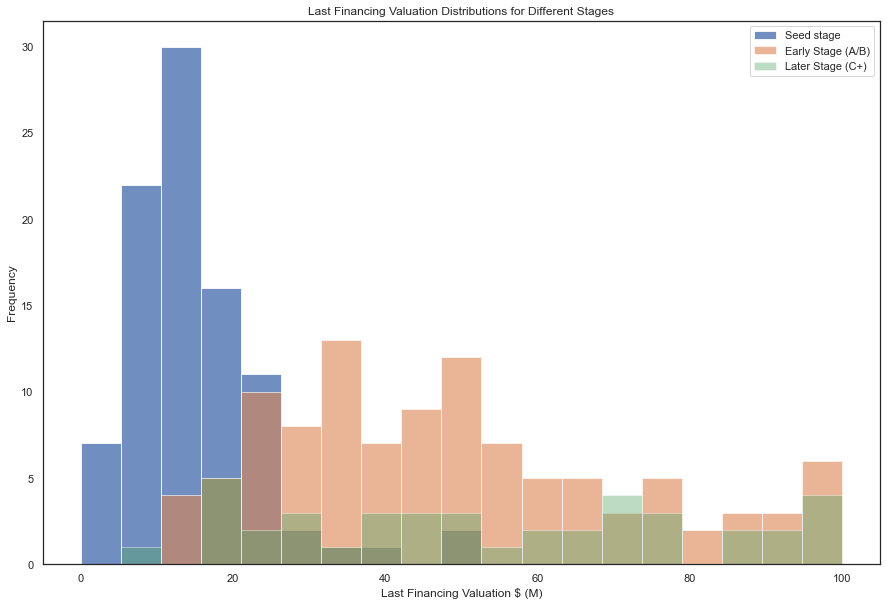

In [8]:
hist_distribution(data_seed, data_early, data_later, "Last Financing Valuation")

### HQ Location Bar Char per Stage

<Figure size 1080x720 with 0 Axes>

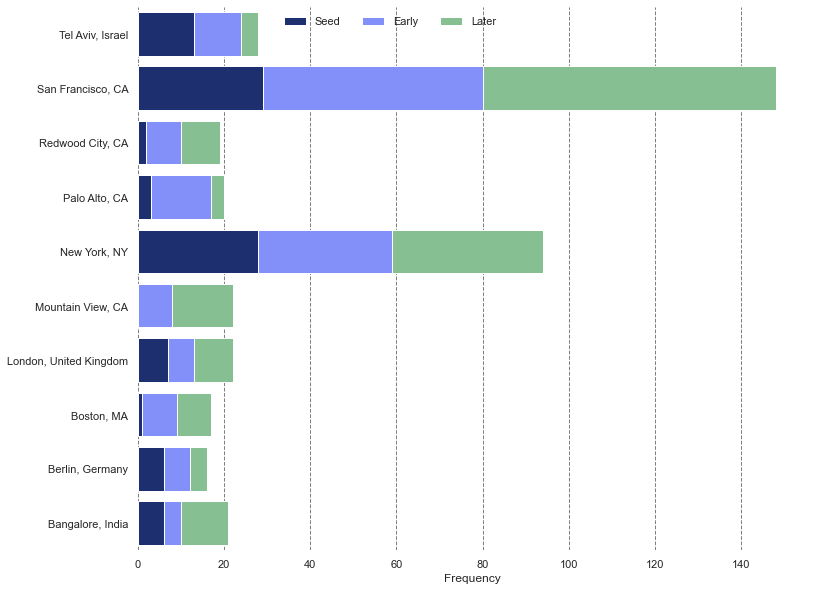

In [9]:
plot_stacked(data, data_seed, data_early, data_later, 'HQ Location', 10)

***notice the high proportion of Seed investments into Israeli based companies**

### Date Founded Bar Char per Stage

<Figure size 1080x720 with 0 Axes>

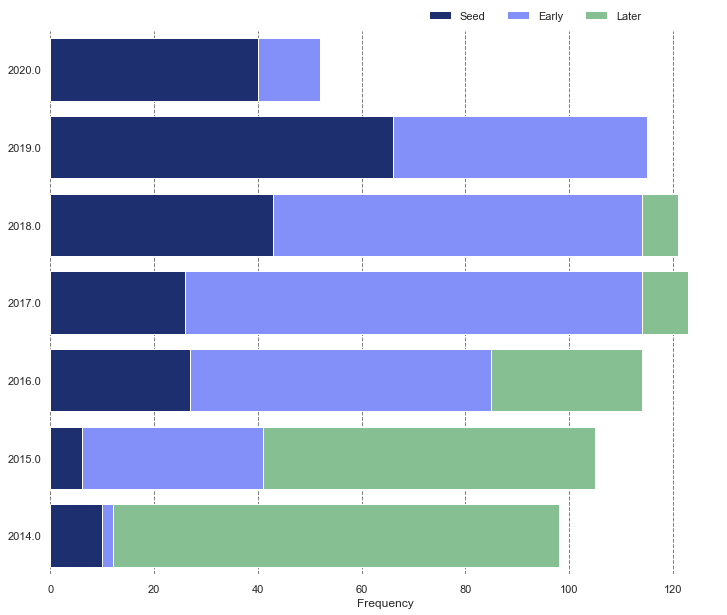

In [10]:
plot_stacked(data, data_seed, data_early, data_later, 'Year Founded', 7)

# Analysis of Industry Trends

### By Vertical

In [11]:
#clean data using aux functions above
data.fillna("", inplace=True)
data.head()
# clean data with the functions above
counts = count_verticals(data, "Verticals")
counts = delete_non_rel_vert(counts)

In [12]:
#order data by most common verticals
verticals = counts.most_common(20)
verticals

[('Big Data', 142),
 ('FinTech', 119),
 ('HealthTech', 79),
 ('Cybersecurity', 67),
 ('E-Commerce', 62),
 ('CloudTech & DevOps', 57),
 ('Life Sciences', 56),
 ('Digital Health', 38),
 ('Mobility Tech', 38),
 ('LOHAS & Wellness', 31),
 ('InsurTech', 30),
 ('Internet of Things', 28),
 ('Industrials', 27),
 ('Robotics and Drones', 26),
 ('HR Tech', 24),
 ('Supply Chain Tech', 24),
 ('FoodTech', 22),
 ('EdTech', 22),
 ('Marketing Tech', 19),
 ('CleanTech', 18)]

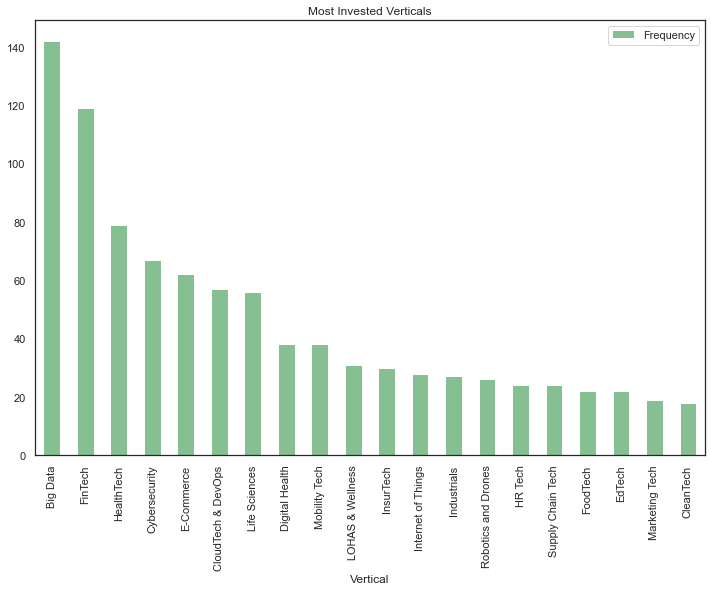

In [13]:
df = pd.DataFrame(verticals, columns=['Vertical', 'Frequency'])
df.plot(kind='bar', x='Vertical', y="Frequency", title="Most Invested Verticals" ,color='#86bf91', zorder=2, figsize=(12,8));

plot_stacked_vert(data_seed, data_early, data_later, "Verticals")

***Notice the high percentage of Life Science related Seed investments**

### By All Industries: Diving Deeper into what defines the above verticals

[('Business/Productivity Software', 396),
 ('Media and Information Services (B2B)', 142),
 ('Application Software', 106),
 ('Financial Software', 97),
 ('Network Management Software', 72),
 ('Automation/Workflow Software', 65),
 ('Other Healthcare Technology Systems', 62),
 ('Other Financial Services', 60),
 ('Information Services (B2C)', 57),
 ('Database Software', 54),
 ('Software Development Applications', 51),
 ('Biotechnology', 50),
 ('Social/Platform Software', 34),
 ('Other Healthcare Services', 30),
 ('Logistics', 30),
 ('Internet Retail', 30),
 ('Communication Software', 28),
 ('Drug Discovery', 27),
 ('Entertainment Software', 27),
 ('Human Capital Services', 26)]

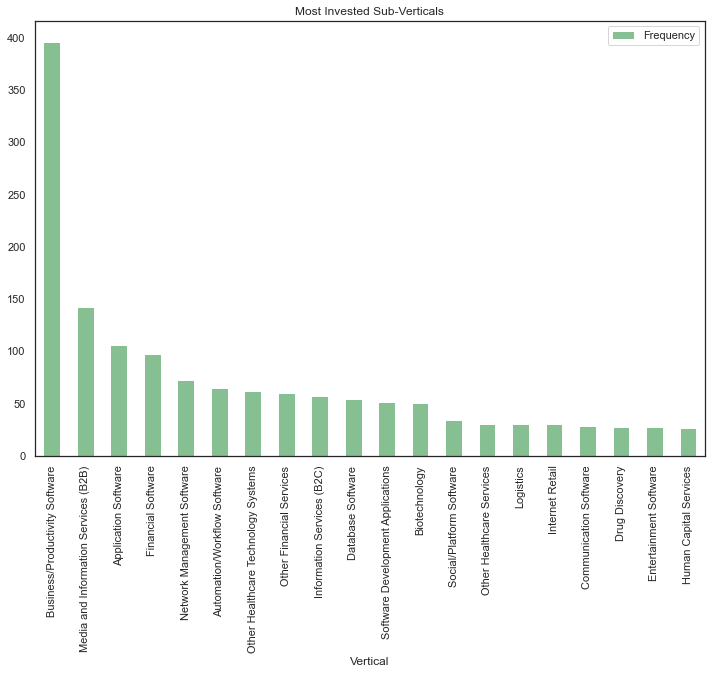

In [14]:
# clean data with the functions above
counts = count_verticals(data, "All Industries")
counts = delete_non_rel_vert(counts)
#order data by most common verticals
verticals = counts.most_common(20)
df = pd.DataFrame(verticals, columns=['Vertical', 'Frequency'])
df.plot(kind='bar', x='Vertical', y="Frequency", title="Most Invested Sub-Verticals" ,color='#86bf91', zorder=2, figsize=(12,8));
verticals

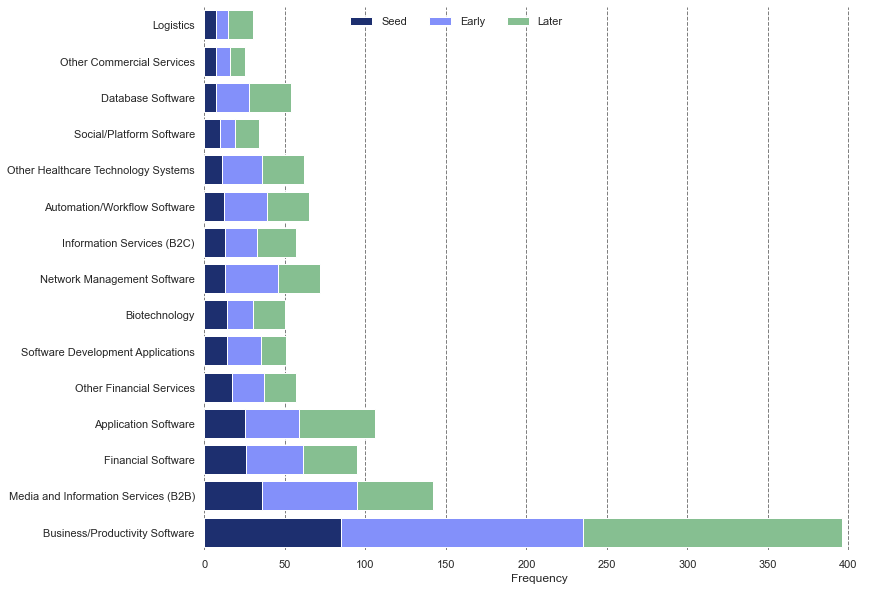

In [15]:
plot_stacked_vert(data_seed, data_early, data_later, "All Industries")

In [20]:
test = data[data['All Industries'].str.contains('Business/Productivity Software')]
test = test[test['All Industries'].str.contains(" Media and Information Services")]
test

# test
# ai_comps = test[test['Keywords'].str.contains("platform|Platform")]
# ai_comps = test[test['Description'].str.contains("artificial intelligence platform|enterprise AI platform|end-to-end|data science")]
# ai_comps

,Company Name,Funding Type,Funding Series,Last Financing Size,Last Financing Valuation,Total Raised,Last Financing Date,Primary Industry Group,Primary Industry Sector,All Industries,Verticals,HQ Location,Year Founded,Active Investors,Keywords,Website,Description,Primary Contact,Primary Contact Email
2,Abacus.AI,Early Stage VC,Series B,22,102,40.25,2020-10-23 00:00:00,Commercial Services,Business Products and Services (B2B),"Business/Productivity Software, IT Consulting ...","Artificial Intelligence & Machine Learning, Bi...","San Francisco, CA",2019,"Avichal Garg, Coatue Management, Decibel Partn...","artificial intelligence platform, artificial i...",www.abacus.ai,Provider of an artificial intelligence platfor...,Bindu Reddy,bindu@abacus.ai
5,Acceldata,Early Stage VC,Series A,8.5,32.5,10.56,2020-10-15 00:00:00,Software,Information Technology,"Business/Productivity Software*, Database Soft...","Artificial Intelligence & Machine Learning, Bi...","Palo Alto, CA",2018,"Ashish Gupta, Emergent Ventures, Girish Mathru...","application performance platform, data analyti...",www.acceldata.io,Developer of an application performance platfo...,Rohit Choudhary,rohit@acceldata.io
10,Adverity,Later Stage VC,Series C,30,,33.95,2020-04-20 00:00:00,Commercial Services,Business Products and Services (B2B),"Business/Productivity Software, Media and Info...","AdTech, Marketing Tech, SaaS, TMT","Vienna, Austria",2014,"42CAP, aws Gründerfonds, Felix Capital, i5inve...","advertising platform, e-marketing platform, ma...",www.adverity.com,Developer of an online marketing platform desi...,Andreas Glanzer,andreas@adverity.com
12,Agile Robots,Early Stage VC,Series A,130,,134.03,2021-01-27 00:00:00,Commercial Services,Business Products and Services (B2B),"Business/Productivity Software, Media and Info...","Artificial Intelligence & Machine Learning, Ro...","Munich, Germany",2018,"BoCom International, C Ventures, CMB Internati...","ai robotics, ai robotics operating system, ai ...",www.agile-robots.com,Developer of an intelligent robotic platform d...,Zhaopeng Chen,zhaopeng.chen@agile-robots.com
15,Airbase (Financial Services),Early Stage VC,Series A,30.5,,30.8,2020-03-05 00:00:00,Software,Information Technology,"Business/Productivity Software, Financial Soft...",FinTech,"San Francisco, CA",,"Bain Capital Ventures, BoxGroup, First Round C...","accounting app, accounting automation, account...",www.airbase.io,Developer of spend management software platfor...,Thejovardhana Kote,thejo.kote@airbase.io
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,Welcome,Early Stage VC,Series A,12,,12.15,2020-11-18 00:00:00,Software,Information Technology,"Business/Productivity Software*, Media and Inf...",TMT,"Berkeley, CA",2017,"Kapor Capital, Kleiner Perkins, Webb Investmen...","event hosting platform, event platform, online...",www.experiencewelcome.com,Developer of a virtual events platform intende...,,
882,Yieldigo,Seed Round,Seed Round,2.35,,2.35,2020-10-07 00:00:00,Software,Information Technology,"Business/Productivity Software*, Media and Inf...","Artificial Intelligence & Machine Learning, Bi...","Prague, Czech Republic",2016,"Alchemist Accelerator, J&T Ventures, Patero, P...","price optimization tool, pricing software, pro...",www.yieldigo.com,Developer of a price optimization software des...,David Klečka,david@yieldigo.com
883,Yotpo,Later Stage VC,Series E,75,,176.3,2020-07-13 00:00:00,Commercial Services,Business Products and Services (B2B),"Business/Productivity Software, Media and Info...","E-Commerce, Marketing Tech, SaaS, TMT","Boston, MA",2011,"2B Angels, Access Industries, ADIP, Arthur Kos...","content marketing, conversion rated, customer ...",www.yotpo.com,Developer of eCommerce marketing platform inte...,Tomer Tagrin,tomer@yotpo.com
888,ZenCity,Later Stage VC,Series B,13.5,39.55,21.5,2020-08-06 00:00:00,Commercial Services,Business Products and Services (B2B),"Business/Productivity Software, Government, In...","Artif

# key Take Aways: Overview

#### 1) Improving short-term productivity is the most popular focus

#### 2) Digitization is the new trend, with a focus on SMEs and emerging markets

#### 3) FinTech is still hot with companies applying existing technologies/business models to new markets/new demographic groups and solving niche problems

#### 4) Remote working is not just about video meeting but means an entirely new workforce management system and a totally different working experience


***

## Trend 1: Productivity tools, Propelled By The Shift to Work-From-Home (WFH)

While productivity tools have been rising in popularity over the years, working from home has created a new industry paradigm. There were **107 companies tagged as Business/Productivity Tools, and Communication Software**. <br> 
Even though these startups are not making huge disruptive innovations, their value added is straightforward and short-term. 

Productivity tools can be broken down into **two groups**:
1. Workflow Automation
2. Data Integration/Visualization:

This space is very hot this year because of the following reasons:

1. **Rise in the number of SaaS aaplications being used by companies ---> tools needed to consolidate those platforms to improve productivity.**
2. **Difficulty to collaborate because of WFH ---> tools are needed to help employees to collaborate.**
3. **Advancements in AI paired with increase in companier offering AI-as-a-service ---> companies can more accuratley solve automated/semi-automated tasks.**
4. **Volatile investment environment ---> VCs potentially looking for low risk products that offer immediate value to customers**


**Conclusion:** <br>
Given that there are too many platforms/tools being used within a single company, a strong trend in companies understanding/integrating/visualization has arisen whereby startups are leveraging existing services APIs from Slack, Salesforce, BIs, DBs etc. <br>to build a platform that enables people to search data, send commands, plan workflows, and sync data across different platforms in one place, essentially increasing productivity and removing data silos. However, it seems that there is a minimal technical entry barrier <br> for many of the productivity tools that these startups are working with. Furthermore, there also seems to be questions marks around scalability in this space, given the relative simplicity to develop similar products.


**Companies**: Sorted by largest seed financing
* **IMPORTANT NOTE: Adjust X in the cell below to see more information per column (Ex. Company Descrition))**
<br>pd.set_option("max_colwidth", X)

## Trend 2: Productivity tools, Propelled By The Shift to Work-From-Home (WFH)

In [ ]:
#Adjust here
pd.set_option("max_colwidth", 50)

### Quantum Drug Discovery

In [ ]:
drug_disc_comps = data[data['Description'].str.contains("quantum")]
# drug_disc_comps = drug_disc_comps[drug_disc_comps['Keywords'].str.contains("quantum")]
drug_disc_comps 

### AI-Dev Platforms

In [ ]:
ai_comps = data_na[data_na['Verticals'].str.contains("Artificial Intelligence & Machine Learning")]
ai_comps = ai_comps[ai_comps['Keywords'].str.contains("platform|Platform")]
ai_comps = ai_comps[ai_comps['Description'].str.contains("artificial intelligence platform|enterprise AI platform|end-to-end|data science")]
ai_comps

In [ ]:
prod_comps
# prod_comps.sort_values(by="Last Financing Size", ascending=False)

In [ ]:
prod_comps = data[data['Verticals'].str.contains("FinTech")]

counts = count_verticals(prod_comps, "All Industries")
counts = delete_non_rel_vert(counts)
#order data by most common verticals
verticals = counts.most_common(20)
verticals
# prod_comps = prod_comps[prod_comps['All Industries'].str.contains("B2B")]

# prod_comps
# prod_comps = prod_comps[['Company Name', 'Website', 'All Industries', 'Last Financing Size', 'Active Investors', 'HQ Location', 'Description', 'Primary Contact Email']]
# pd.set_option("max_colwidth", None)
# prod_comps.sort_values(by="Last Financing Size", ascending=False)

In [ ]:
prod_comps = prod_comps[prod_comps['Keywords'].str.contains("lending")]


In [ ]:
prod_comps

In [ ]:

# IL = prod_comps = IL[IL['All Industries'].str.contains("Business/Productivity Software")]

In [ ]:
IL

VC Funds: **8VC, Accel, ALLVP, Alumni Ventures Group, Andreessen Horowitz, Bain Capital Ventures, Benchmark, Bessemer Venture Partners, Canary, First Round Capital, Foundation Capital, Founders Fund, General Catalyst, GGV Capital, Global Founders Capital, Gradient Ventures, Greylock, GV, Index Ventures, Initialized Capital, Jerusalem Venture Partners (JVP), Khosla Ventures, Kleiner Perkins, Lightspeed China Partners, Lightspeed India Partners, Lightspeed Venture Partners, Lowercase Capital, Magma Venture Partners, Menlo Ventures, Monashees, New Enterprise Associates, Differential Ventures, Sequoia Capital, Sequoia Capital (SSF), Sequoia Capital China, Sequoia Capital India, Sequoia Capital Israel, Social Capital, SV Angel, True Ventures, Two Sigma Ventures, Venrock, Vertex Ventures, Vertex Ventures Israel, Team8, Viola, Pitango, Cyberstarts, UpWest, 83North**

#### Print dependences

In [ ]:
%load_ext watermark

%watermark -v -m -p pandas,numpy,watermark,seaborn,matplotlib,tabulate,xlrd

In [ ]:
print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

In [ ]:
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import watermark
from tabulate import tabulate


# get rid of warnings
import warnings
warnings.filterwarnings('ignore')

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
from collections import Counter
# visualization
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline
# Plot styling
sns.set(style='white', context='notebook', palette='deep')
plt.rcParams[ 'figure.figsize' ] = 9 , 5
pd.set_option("max_colwidth", 250)